# Somewhat similar to this paper

max projection -> median filter -> activate contour

In [201]:
from DLC_for_WBFM.utils.projects.finished_project_data import finished_project_data
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import ndimage as ndi
from skimage import measure
from skimage.measure import label, regionprops
import napari, zarr
from skimage.transform import PiecewiseAffineTransform, warp
from scipy.spatial import KDTree
from skimage.feature import peak_local_max, blob_dog
# from skimage.filters import median
from skimage.filters.rank import median
import matplotlib.pyplot as plt

In [202]:
fname = "/project/neurobiology/zimmer/wbfm/dlc_stacks_updated/Charlie-worm3-new-seg/project_config.yaml"
dat_worm3 = finished_project_data.load_final_project_data_from_config(fname)

# fname = "/project/neurobiology/zimmer/wbfm/dlc_stacks_updated/Charlie-worm3-new-seg/project_config.yaml"
# dat_gfp = finished_project_data.load_final_project_data_from_config(fname)

In [203]:
fname = "/project/neurobiology/zimmer/wbfm/dat/ZIM2051/2021-03-04_16-07-57_worm3_ZIM2051/2021-03-04_16-07-57_worm3_ZIM2051-channel-0-pco_camera1/2021-03-04_16-07-57_worm3_ZIM2051-channel-0-pco_camera1bigtiff.zarr"
dat_red = zarr.open(fname)
dat_red.shape

fname = "/project/neurobiology/zimmer/wbfm/dat/ZIM2051/2021-03-04_16-07-57_worm3_ZIM2051/2021-03-04_16-07-57_worm3_ZIM2051-channel-1-pco_camera2/2021-03-04_16-07-57_worm3_ZIM2051-channel-1-pco_camera2bigtiff.zarr"
dat_green = zarr.open(fname)
dat_green.shape

(1500, 32, 700, 900)

In [209]:
np.max(dat_red[0:10,...]) / 0.15

1273.3333333333335

In [211]:
np.max(dat_red[-10:,...]) / 0.15

760.0

In [210]:
np.max(dat_green[0:10,...]) / 0.15

793.3333333333334

In [212]:
np.max(dat_green[-10:,...]) / 0.15

446.6666666666667

# Get a volume and filter

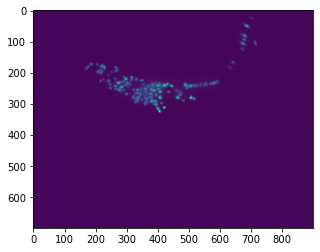

In [37]:
i_frame = 1
vol = np.array(dat_red[i_frame, 1:, ...])

%matplotlib inline
projection = np.max(vol, axis=0)
plt.imshow(projection)

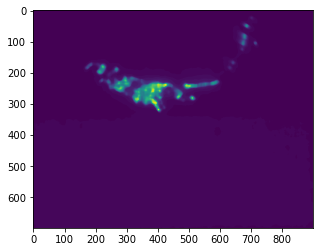

In [55]:
element = np.ones((15,15))
med_filter = median(projection, selem=element)

plt.imshow(med_filter)

0.20870862205986632

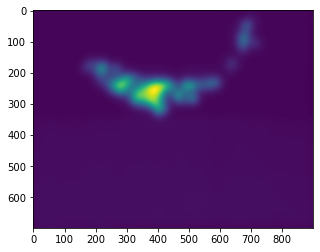

In [88]:
from skimage import filters

g_filter = filters.gaussian(projection, sigma=15)

plt.imshow(g_filter)

np.max(g_filter)

In [89]:
# from skimage.filters import threshold_otsu

# thresh = threshold_otsu(image=g_filter)
# thresh_img = projection.copy() > thresh

# plt.imshow(thresh_img)

In [90]:
# element = np.ones((25,25))
# med_filter = median(thresh_img.astype(int), selem=element)

# plt.imshow(med_filter)

In [91]:
# from skimage.morphology import convex_hull_image
# from skimage.util import invert
# chull = convex_hull_image(thresh_img)

# plt.imshow(chull)

In [92]:
# from skimage.morphology import skeletonize

# skeleton = skeletonize(chull)

# plt.imshow(thresh_img)
# plt.imshow(skeleton, alpha=0.5)

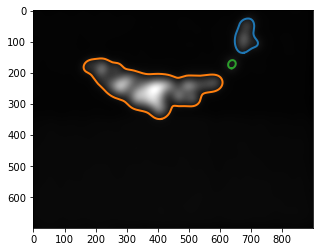

In [96]:
contours = measure.find_contours(g_filter, 0.07)

fig, ax = plt.subplots()
ax.imshow(g_filter, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

# Try 2: background subtraction

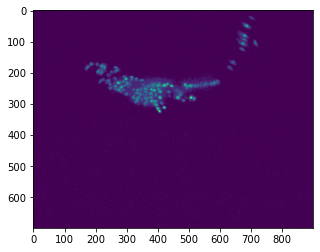

In [98]:
i_frame = 1
vol = np.array(dat_red[i_frame, 1:, ...])

%matplotlib inline
projection = np.max(vol, axis=0)

thresh = 18
projection[projection < thresh] = 0

plt.imshow(projection)

0.208273889438471

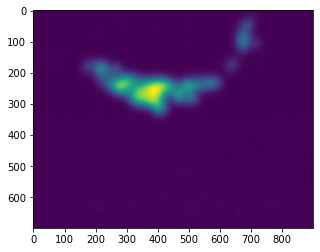

In [99]:
from skimage import filters

g_filter = filters.gaussian(projection, sigma=15)

plt.imshow(g_filter)

np.max(g_filter)

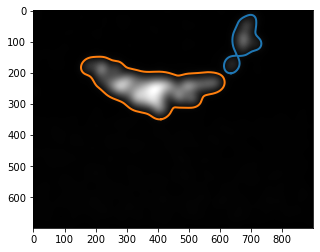

In [105]:
contours = measure.find_contours(g_filter, 0.01)

fig, ax = plt.subplots()
ax.imshow(g_filter, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

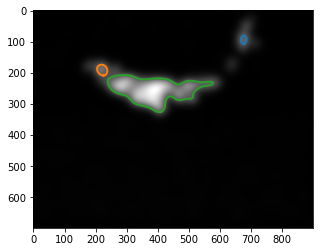

In [127]:
contours = measure.find_contours(g_filter, 0.07)

fig, ax = plt.subplots()
ax.imshow(g_filter, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

In [121]:
from skimage.draw import polygon_perimeter, polygon2mask

c = contours[1]

mask = polygon2mask(g_filter.shape, c)

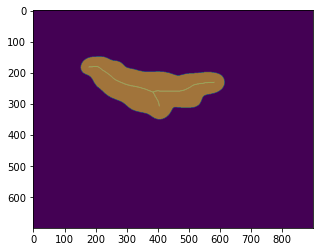

In [123]:
from skimage.morphology import skeletonize

skeleton = skeletonize(mask)

plt.imshow(mask)
plt.imshow(skeleton, alpha=0.5)

# Try 3: just do a bounding box

In [ ]:
from skimage.measure import label, regionprops

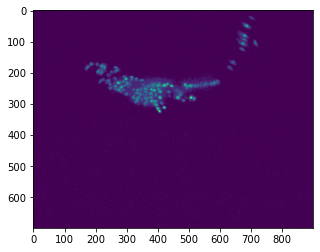

In [193]:
i_frame = 1
vol = np.array(dat_red[i_frame, 1:, ...])

%matplotlib inline
projection = np.max(vol, axis=0)

thresh = 18
projection[projection < thresh] = 0

plt.imshow(projection)

(0.149838459720172, 0.0015714997494944143)

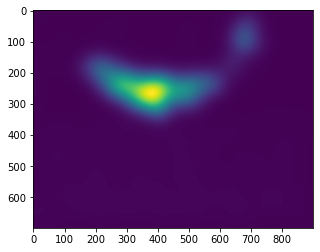

In [148]:
from skimage import filters

g_filter = filters.gaussian(projection, sigma=30)
plt.imshow(g_filter)

np.max(g_filter), np.median(g_filter)

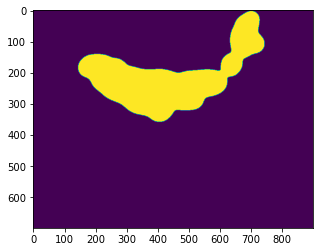

In [140]:
thresh = 0.004
g_binary = (g_filter > thresh).astype(int)

plt.imshow(g_binary)

In [143]:
props = regionprops(g_binary)

props[0].bbox

(3, 145, 359, 744)

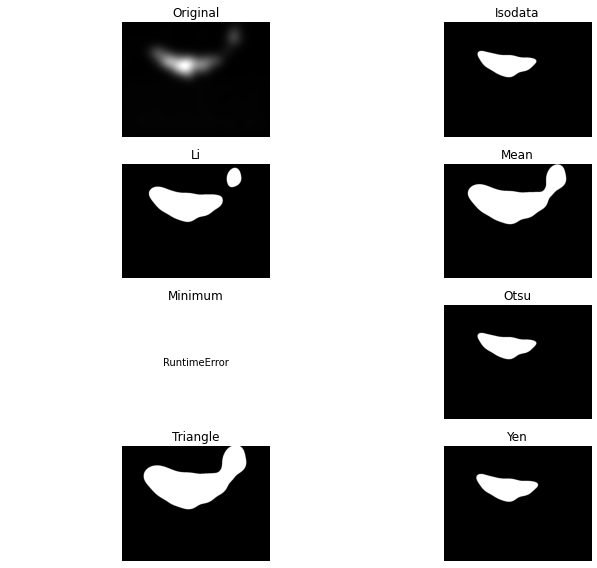

In [149]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(g_filter, figsize=(10, 8), verbose=False)
plt.show()

In [ ]:
from skimage.filters import threshold_mean
from skimage.draw import rectangle

In [177]:
%%timeit
# MEDIAN STRATEGY
element = np.ones((15,15))
g_filter = median(projection, selem=element)

thresh = threshold_mean(g_filter)
g_binary = (g_filter > thresh).astype(int)

props = regionprops(g_binary)
bbox = props[0].bbox

# plt.imshow(g_binary)

mask = np.zeros_like(g_binary, dtype=bool)
rr, cc = rectangle(start=bbox[0:2], end=bbox[2:], shape=mask.shape)
mask[rr, cc] = True
# plt.imshow(mask, alpha=0.8)

183 ms ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [198]:
# %%timeit
# GAUSSIAN STRATEGY
g_filter = filters.gaussian(projection, sigma=8)

thresh = threshold_mean(g_filter)
g_binary = (g_filter > thresh).astype(int)

props = regionprops(g_binary)
bbox = props[0].bbox

# plt.imshow(g_binary)

mask = np.zeros_like(g_binary, dtype=bool)
rr, cc = rectangle(start=bbox[0:2], end=bbox[2:], shape=mask.shape)
mask[rr, cc] = True
# plt.imshow(mask, alpha=0.8)

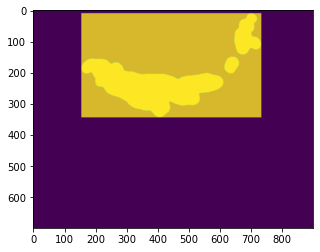

In [199]:

plt.imshow(g_binary)
plt.imshow(mask, alpha=0.8)

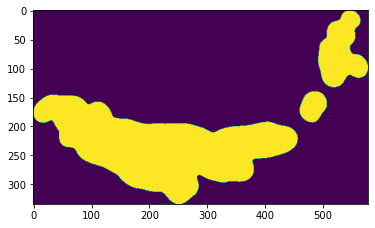

In [200]:

plt.imshow(g_binary[bbox[0]:bbox[2], bbox[1]:bbox[3]])

In [182]:
bbox

(21, 166, 330, 722)

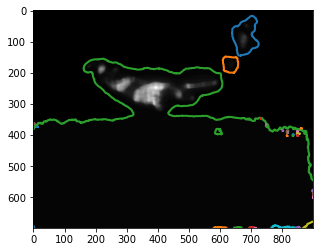

In [35]:
contours = measure.find_contours(med_filter, 15.0)

fig, ax = plt.subplots()
ax.imshow(med_filter, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

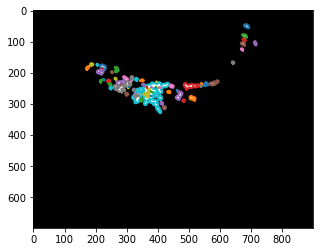

In [42]:
contours = measure.find_contours(thresh_img, 0.5)

fig, ax = plt.subplots()
ax.imshow(thresh_img, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)